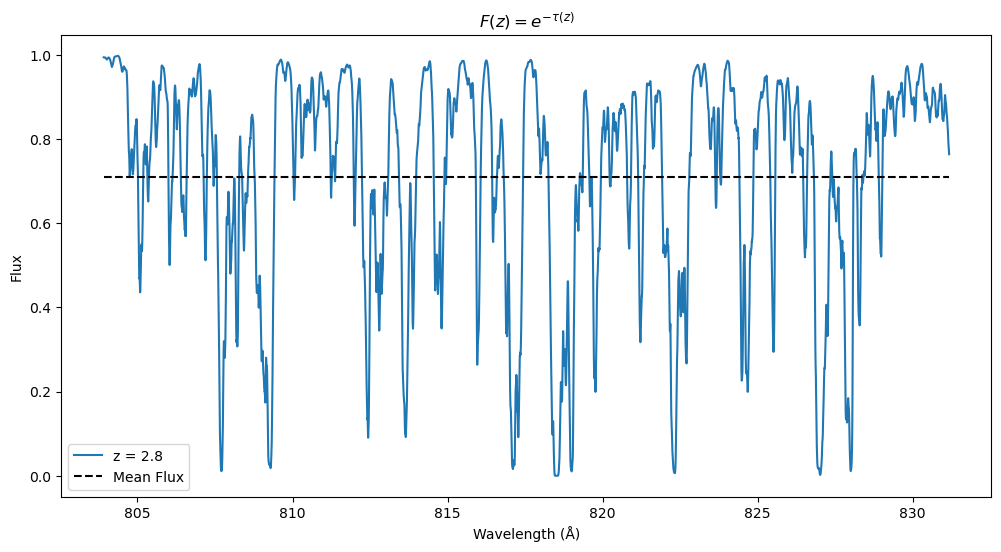

/tmp/ipykernel_1447210/2742158254.py:213: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z) * np.exp(2 * (redshift_evolution(z,z0)) * x)))


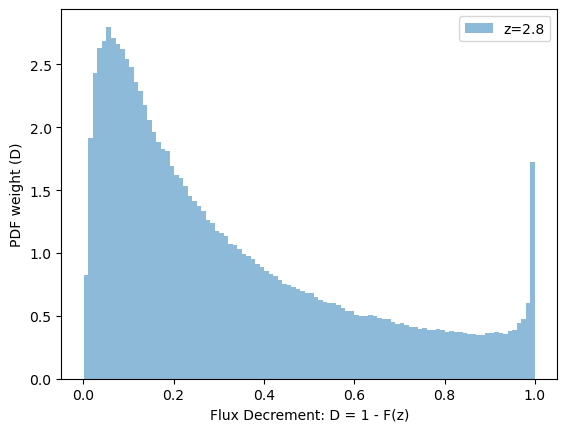

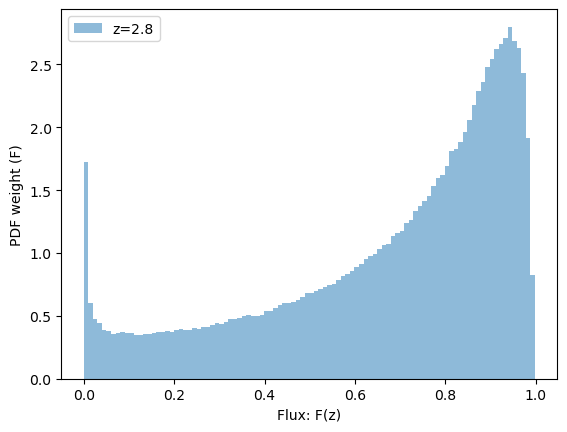

In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm

import scipy as sp
from scipy.fft import fft, ifft, rfft, irfft
from scipy.stats import binned_statistic 
from scipy import integrate

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

from numpy.polynomial.hermite import hermgauss

###############################################################################


# constants
c = 299792.458  # speed of light in km/s


# get from user inputs (e.g. argparse)
seed = 10      # for repeatability
size = 2**20
z = 2.8
z0 = 3

flux_plot  = True
pdf_f_plot = True
pdf_d_plot = True



###############################################################################



# wavelength grid
def wavelength_field(z, grid_size, lambda_min = 3600, lambda_max=9800, lambda_0 = 1216):
    velocity_grid = np.arange(grid_size) - grid_size/2
    
    lambda_c = (1+z)*lambda_0

    wavelength_field = lambda_c * (np.exp(velocity_grid / c))
    return(wavelength_field)



# gaussian random grid
def gaussian_field_v(grid_size=size, seed=None, plot=False):
    size = grid_size
    # Generate Gaussian random field in velocity-space
    gaussian_random_field = np.random.default_rng(seed).normal(size=grid_size)
    
    if plot==True:
        plt.plot(gaussian_random_field)
        plt.title('Gaussian Random Field, Velocity Space')
        plt.xlabel('Points')
        plt.ylabel('Velocity (km/s)')
        
    return(gaussian_random_field)

def gaussian_field_k(grid_size=size, seed=None, plot=False):
    size = grid_size
    # Generate Gaussian random field in velocity-space
    gaussian_random_field = np.random.default_rng(seed).normal(size=grid_size)
    
    # Compute the FFT to get the field in k-space
    gaussian_field_k = np.fft.rfft(gaussian_random_field) # normalization ?
    
    if plot==True:
        plt.plot(np.real(gaussian_field_k))
        plt.title('RFFT(1D field), k-space (Real part)')
        plt.xlabel('k-modes')
        plt.ylabel('Amplitude')
        
    return(gaussian_field_k)


v_field = gaussian_field_v(size,seed)
k_field = gaussian_field_k(size,seed)

###############################################################################


# make grid of k-modes
def make_kmodes(grid_size=size, spacing=1):
    kmodes = (np.fft.rfftfreq(n=grid_size, d=spacing) * 2 * np.pi) + 1e-12 # factor of 2pi
    return(kmodes)


kmodes = make_kmodes(size, spacing=1)

###############################################################################

# rebin k-modes
def rebin_kmodes(kmodes, array, kmode_spacing=1, stat='mean', bin_num=40):
    # returns an averaged / smoothed array by rebinning kmodes over a number of bins
    # e.g. smoothing measured power over 40 k-modes, rather than thousands

    statistic, bin_edges, binnumber = binned_statistic(x = kmodes, values = array,
                                                    statistic = stat, bins=bin_num)
    return(statistic)



# Measure Power
def measure_power(array):
    power = np.abs(array)**2
    return(power)

def measure_scaled_power(array, n, length_scale=1):
    #scale power as P(k)/L, where n=number of points or size and L=n*len_scale
    power = np.abs(array)**2
    scaled_power = power / (n * length_scale)
    return(scaled_power)



# Input Power Spectrum model 
def power_spectrum(k, k0=0.001, k1 = 0.04, n=0.5, alpha=0.26, gamma=1.8, plot=False):    
    #k = input k-modes 
    pk = ( (k / k0)**(n - alpha * np.log(k / k0)) ) / (1 + (k / k1)**gamma)
    pk_i = np.arange(len(pk))
    
    mask = np.isfinite(pk)
    pk_filtered=np.interp(pk_i, pk_i[mask], pk[mask])
    
    if plot == True: 
        plt.loglog(k[1:],power_spectrum(k[1:]), color='tab:blue')
        plt.title(r'$P(k) = \frac{(k / k_0)^{n - \alpha \ln(k/k_0)}}{1 + (k/k_1)^{\gamma}}$')
        plt.xlabel('k-modes')
        plt.ylabel('P(k)')
    return(pk_filtered)



# Delta transform
def delta_transform(k_field, kmodes, dv=1, k0=0.001, k1 = 0.04, n=0.5, alpha=0.26, gamma=1.8):
    delta_b_tilde = k_field * np.sqrt(power_spectrum(kmodes,k0,k1,n,alpha,gamma) / dv)  # multiply k-space field by p(k) expression above
    delta_b = np.fft.irfft(delta_b_tilde)             # inverse rfft back to v-space
    return(delta_b)


delta_b_v = delta_transform(k_field, kmodes)
variance_1d = delta_b_v.var() # sigma^2

###############################################################################


# redshift evolution factor
def redshift_evolution(z, z0, a=58.6, b=-2.82):
    a_z = np.sqrt(a * (((1+z)/(1+z0))**(b)))    
    return(a_z)

delta_b_z = delta_b_v * redshift_evolution(z,z0)
redshifted_variance_1d = variance_1d * redshift_evolution(z,z0)**2

###############################################################################

# lognormal transformation
def lognormal_transform(delta_z, variance):
    n_z = np.exp( (2 * (delta_z) - (variance)))
    return(n_z)

n_z = lognormal_transform(delta_b_z, redshifted_variance_1d)

###############################################################################

# optical depth transform
def optical_depth_transform(n_z, z=2.8, z0=3, c=0.55, d=5.1):
    tau_z = c * (((1+z)/(1+z0))**d) * n_z
    return(tau_z)

tau_z = optical_depth_transform(n_z, z, z0)

###############################################################################

def flux(tau):
    F_z = np.exp(-(tau))
    return(F_z)

f_z = flux(tau_z)
    
# option to plot flux at a given redshift (z)
def plot_flux(z):
    # Generate the wavelength grid
    lambda_field = wavelength_field(z, size)
    
    if flux_plot==True:  # Use global flux_plot directly
        # Plot the flux vs wavelength
        plt.figure(figsize=(12, 6))
        plt.plot(lambda_field[:10000], f_z[:10000], label='z = ' + str(z))  # Use wavelength_field for x-axis and flux_z for y-axis
        plt.title(r'$ F(z) = e^{-\tau(z)}$')
        plt.xlabel('Wavelength (Å)')
        plt.ylabel('Flux')
        plt.hlines(y=f_z[:10000].mean(), xmin=lambda_field[:10000].min(), xmax=lambda_field[:10000].max(), color='black', ls='--', label='Mean Flux')
        plt.legend()
        plt.show()
    else:
        pass
plot_flux(z)


# calculate mean flux using quad integration
def mean_flux(z, variance, z0=3):
    prefactor = 1 / (np.sqrt(variance) * np.sqrt(2 * np.pi))
    x_z = 0.55 * (((1+z)/(1+z0))**5.1) * (np.exp(-((redshift_evolution(z,z0))**2) * variance))
    integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z) * np.exp(2 * (redshift_evolution(z,z0)) * x)))
    integral = integrate.quad(integrand, -np.inf, np.inf)[0]
    value = prefactor * integral
    return(value)
f_bar = mean_flux(z,variance_1d, z0)

# gauss hermite quadrature mean flux (faster, less change of overflow errors)
def gh_mean_flux(z, variance, z0=3, n=10):
    # Parameters
    sigma = np.sqrt(variance_1d)
    a_z = redshift_evolution(z,z0)
    x_z = 0.55 * (((1+z)/(1+z0))**5.1) * (np.exp(-((redshift_evolution(z,z0))**2) * variance))
    beta = x_z

    # Number of Gauss-Hermite nodes
    N = n

    # Compute Gauss-Hermite nodes and weights
    nodes, weights = hermgauss(N)

    # Transform nodes for the given problem
    transformed_nodes = np.sqrt(2 * sigma**2) * nodes

    # Compute the function values
    function_values = np.exp(-beta * np.exp(2 * a_z * transformed_nodes))

    # Compute the integral approximation
    integral_approximation = np.sqrt(2 * sigma**2) * np.sum(weights * function_values)

    # multiply by prefactor
    gh_prefactor = 1 / np.sqrt(2 * np.pi * variance)
    integral_approximation = integral_approximation * gh_prefactor
    
    return(integral_approximation)
f_bar_gh = gh_mean_flux(z,variance_1d, z0, n=10)



###############################################################################

# PDF of flux and flux decrement 

def pdf_d(z, variance, gaussian_k_field, input_kmodes, z0=3, color=None):
    delta_z = (delta_transform(k_field=gaussian_k_field, kmodes=input_kmodes, dv=1)) * redshift_evolution(z, z0)
    redshifted_variance = variance * redshift_evolution(z, z0)**2
    f_z_vals = flux(optical_depth_transform(lognormal_transform(delta_z, redshifted_variance)))
    
    if pdf_d_plot==True:
        plt.hist((1 - f_z_vals),
                 bins=100, alpha=0.5, label='z='+str(z), color=color, density=True, stacked=True)
        plt.xlabel('Flux Decrement: D = 1 - F(z)')
        plt.ylabel('PDF weight (D)')
        plt.legend()
        plt.show()
    else:
        pass
    
def pdf_f(z, variance, gaussian_k_field, input_kmodes, z0=3, color=None):
    delta_z = (delta_transform(k_field=gaussian_k_field, kmodes=input_kmodes, dv=1)) * redshift_evolution(z, z0)
    redshifted_variance = variance * redshift_evolution(z, z0)**2
    f_z_vals = flux(optical_depth_transform(lognormal_transform(delta_z, redshifted_variance)))

    if pdf_f_plot==True:
        plt.hist((f_z_vals),
                 bins=100, alpha=0.5, label='z='+str(z), color=color, density=True, stacked=True)
        plt.xlabel('Flux: F(z)')
        plt.ylabel('PDF weight (F)') 
        plt.legend()
        plt.show()
    else:
        pass
    
pdf_d(z, variance_1d, k_field, kmodes, z0)
pdf_f(z, variance_1d, k_field, kmodes, z0)
    

###############################################################################

